# Setup
## Imports

In [5]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime as dt
from matplotlib.ticker import FormatStrFormatter

from collections import defaultdict
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

import pickle

/Users/Arjun/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
plt.rcdefaults()

In [12]:
sns.set(style='darkgrid')

## Preview Submission Format

In [3]:
file = 'Pump_it_Up_Data_Mining_the_Water_Table_-_Submission_format.csv'
submission = pd.read_csv(file)
submission.head()

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label


## Load Training Data

In [13]:
def load_training_data():
    values = 'Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv'
    labels = 'Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv'
    df1 = pd.read_csv(values)
    df2 = pd.read_csv(labels)

    df = df1.merge(df2, on='id')
    df['date_recorded'] = pd.to_datetime(df['date_recorded'], format='%Y-%m-%d')
    return df

In [14]:
df = load_training_data()
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Exploratory Data Analysis

In [15]:
df.shape

(59400, 41)

In [16]:
df.dtypes

id                                int64
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                        int64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                       int64
basin                            object
subvillage                       object
region                           object
region_code                       int64
district_code                     int64
lga                              object
ward                             object
population                        int64
public_meeting                   object
recorded_by                      object
scheme_management                object
scheme_name                      object
permit                           object
construction_year                 int64
extraction_type                  object


In [44]:
df.dtypes.value_counts()

object            29
int64             10
float64            3
datetime64[ns]     1
dtype: int64

In [17]:
# make sure there aren't multiple entries per waterpoint id
ids = df.groupby('id')[['status_group']].count()
ids[ids['status_group'] > 1].count()

status_group    0
dtype: int64

## Distribution of Target Label

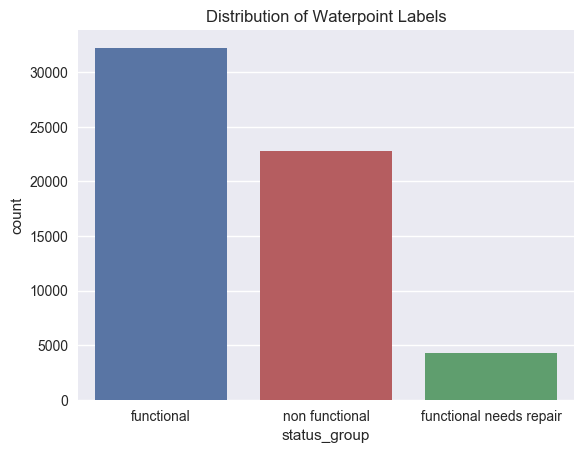

In [18]:
colors = sns.color_palette(palette='deep')
palette = {"functional":colors[0],
           "non functional":colors[2],
           "functional needs repair":colors[1]}

sns.countplot(df['status_group'], palette=palette)
plt.title('Distribution of Waterpoint Labels')
plt.show();

In [19]:
target_proportions = pd.DataFrame(pd.concat([df['status_group'].value_counts().rename('count'),
                                             df['status_group'].value_counts(normalize=True).rename('share')], axis=1))
target_proportions

,count,share
functional,32259,0.543081
non functional,22824,0.384242
functional needs repair,4317,0.072677


- Imbalanced classes, especially for "functional needs repair". That's probably the most useful label in a real-world setting, since these waterpoints are likely to become non functional if left unaddressed.

## Pair Plots

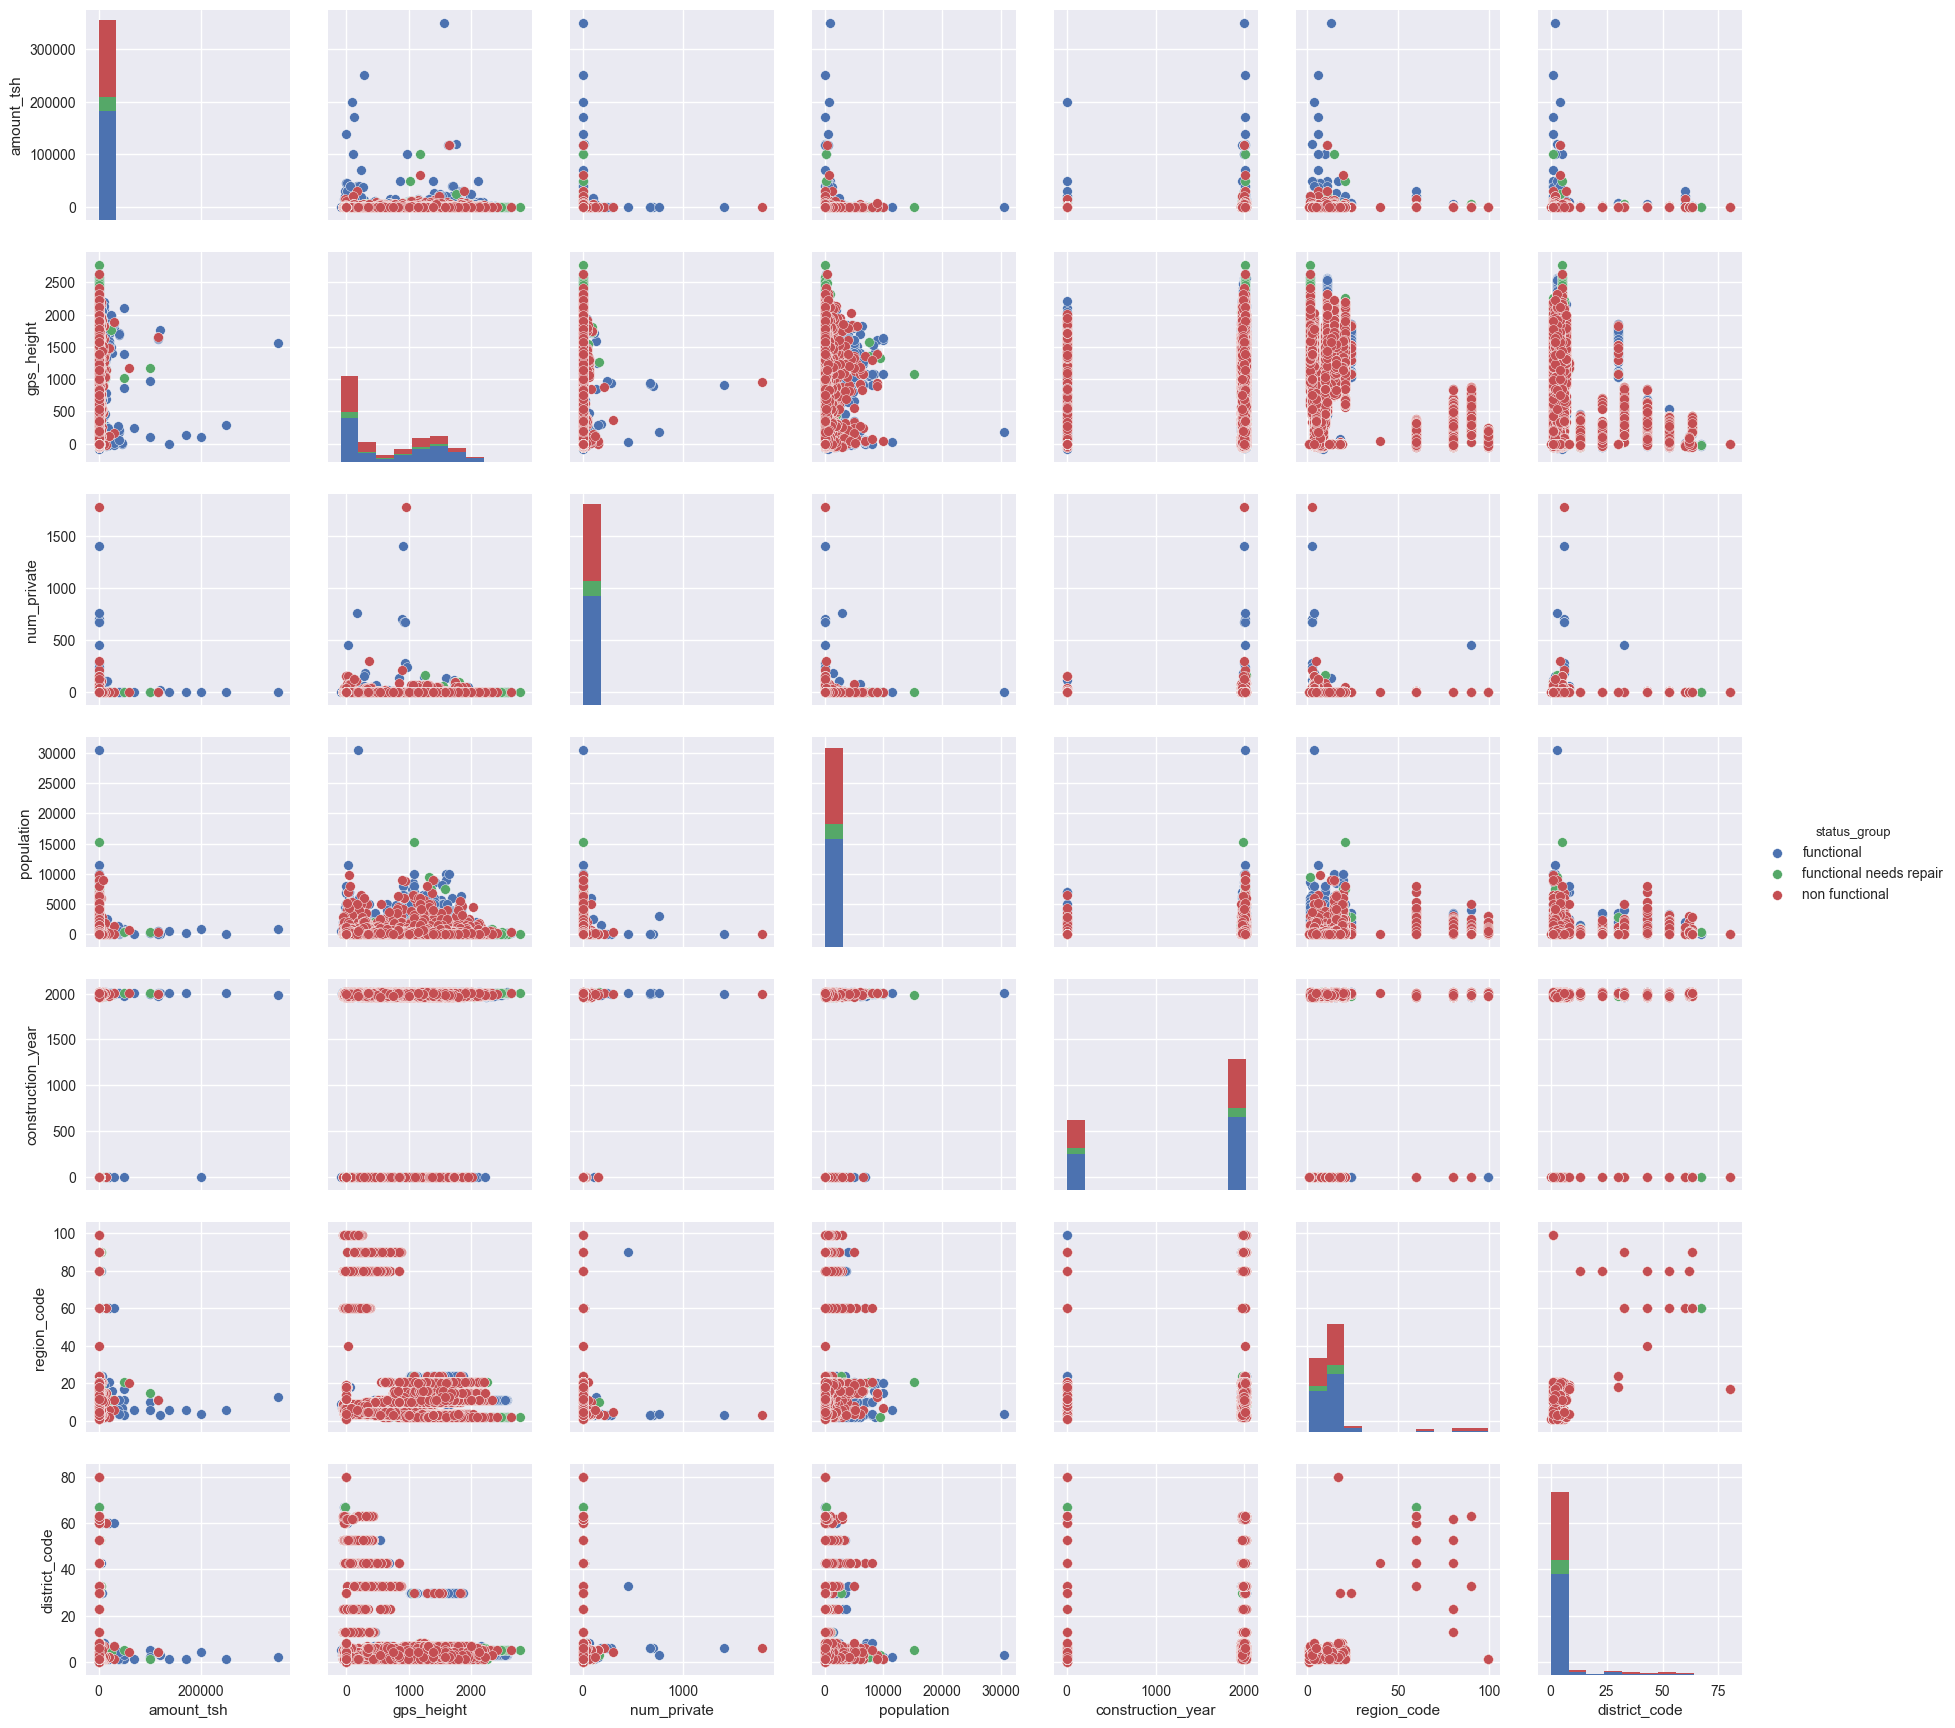

In [220]:
numerical = ['amount_tsh','gps_height','num_private','population','construction_year','region_code','district_code']
sns.pairplot(df,vars=numerical,hue='status_group',hue_order=['functional','functional needs repair','non functional']);

## Features In-Depth

### Amount TSH
`amount_tsh` - Total static head (amount water available to waterpoint)  
- Calculate the mean, minimum, and maximum levels of `amount_tsh` that are associated with each waterpoint status
  - i.e. Are there any patterns in total static head / amount water available for non-functional and needs-repair waterpoints?

In [13]:
df['amount_tsh'].groupby(df['status_group']).describe()

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,32259.0,461.798235,3889.735284,0.0,0.0,0.0,50.0,350000.0
functional needs repair,4317.0,267.071577,1925.026420,0.0,0.0,0.0,50.0,100000.0
non functional,22824.0,123.481230,1110.120571,0.0,0.0,0.0,0.0,117000.0


- Interesting, there are "functional" waterpoints with 0 TSH (see minimum column)
- Conversely, "non functional" waterpoints with >0 TSH (look at mean)

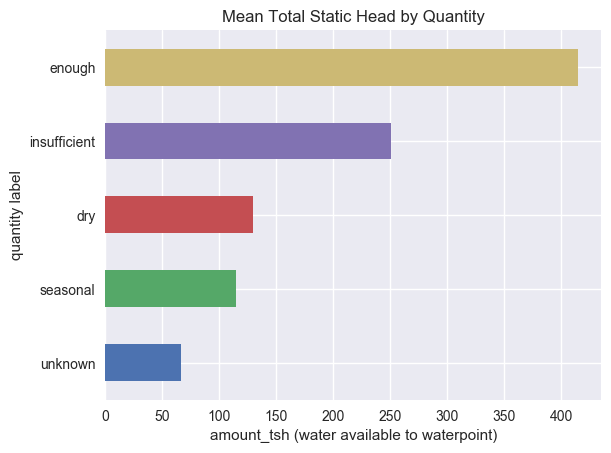

In [20]:
df.groupby(['quantity'])['amount_tsh'].mean().sort_values().plot('barh')
plt.xlabel('amount_tsh (water available to waterpoint)')
plt.ylabel('quantity label')
plt.title('Mean Total Static Head by Quantity')
plt.show();

In [15]:
df.groupby(['status_group','quantity'])[['amount_tsh']].mean().unstack()

amount_tsh                                       \
quantity                        dry      enough insufficient    seasonal   
status_group                                                               
functional                62.292994  539.701832   355.833628  158.002151   
functional needs repair  218.918919  346.086667   190.710345   90.649038   
non functional           130.602280  135.631232   120.829846   45.611154   

                                    
quantity                   unknown  
status_group                        
functional               92.816901  
functional needs repair   0.000000  
non functional           57.802491

In [16]:
df.groupby(['status_group','quantity'])[['amount_tsh']].describe()

amount_tsh                                \
                                          count        mean          std  min   
status_group            quantity                                                
functional              dry               157.0   62.292994   256.984167  0.0   
                        enough          21648.0  539.701832  3949.375721  0.0   
                        insufficient     7916.0  355.833628  4339.377286  0.0   
                        seasonal         2325.0  158.002151   605.737714  0.0   
                        unknown           213.0   92.816901   384.634781  0.0   
functional needs repair dry                37.0  218.918919   749.638927  0.0   
                        enough           2400.0  346.086667  2292.470440  0.0   
                        insufficient     1450.0  190.710345  1464.227154  0.0   
                        seasonal          416.0   90.649038   731.165969  0.0   
                        unknown            14.0    0.000000     0.000000  0.0   
non functional          dry              6052.0  130.602280  1632.088608  0.0   
                        enough           9138.0  135.631232   977.513171  0.0   
                        insufficient     5763.0  120.829846   716.785057  0.0   
                        seasonal         1309.0   45.611154   443.604150  0.0   
                        unknown           562.0   57.802491   291.426851  0.0   

                                                                 
                                      25%  50%    75%       max  
status_group            quantity                                 
functional              dry           0.0  0.0    0.0    2200.0  
                        enough        0.0  0.0  200.0  250000.0  
                        insufficient  0.0  0.0   30.0  350000.0  
                        seasonal      0.0  0.0    0.0    5000.0  
                        unknown       0.0  0.0    0.0    3000.0  
functional needs repair dry           0.0  0.0    0.0    3000.0  
                        enough        0.0  0.0  250.0  100000.0  
                        insufficient  0.0  0.0    0.0   50000.0  
                        seasonal      0.0  0.0    0.0   14000.0  
                        unknown       0.0  0.0    0.0       0.0  
non functional          dry           0.0  0.0    0.0  117000.0  
                        enough        0.0  0.0    0.0   60000.0  
                        insufficient  0.0  0.0    0.0   20000.0  
                        seasonal      0.0  0.0    0.0   14000.0  
                        unknown       0.0  0.0    0.0    3000.0

In [17]:
status_quantity = df.groupby(['status_group','quantity']).count()['id'].unstack(fill_value=0)
status_quantity['total'] = status_quantity.sum(axis=1)
status_quantity['% enough'] = status_quantity['enough'] / status_quantity['total']
status_quantity['% seasonal'] = status_quantity['seasonal'] / status_quantity['total']
status_quantity['% dry/insufficient/unknown'] = (status_quantity['dry'] + 
                                                 status_quantity['insufficient'] + 
                                                 status_quantity['unknown']) / status_quantity['total']
status_quantity['% enough/seasonal'] = (status_quantity['enough'] + 
                                        status_quantity['seasonal']) / status_quantity['total']
status_quantity

quantity,dry,enough,insufficient,seasonal,unknown,total,% enough,% seasonal,% dry/insufficient/unknown,% enough/seasonal
status_group,,,,,,,,,,
functional,157,21648,7916,2325,213,32259,0.671069,0.072073,0.256859,0.743141
functional needs repair,37,2400,1450,416,14,4317,0.555942,0.096363,0.347695,0.652305
non functional,6052,9138,5763,1309,562,22824,0.400368,0.057352,0.542280,0.457720


- Here we find non functional, dry waterpoints with a mean of 130 TSH
- More questionable are the functional waterpoints for every "quantity" where TSH equals 0 (the minimum)
- The combination of dry, insufficient, or unknown seems to be a good signal for status group

In [18]:
tsh_0_func = ((df['amount_tsh'] == 0) & (df['status_group'] == 'functional'))
tsh_non0_nonfunc = (df['amount_tsh'] > 0) & (df['status_group'] == 'non functional')

print('Count of suspicious records:')
print('{:,} functional waterpoints with 0 TSH'.format(len(df[tsh_0_func])))
print('{:,} non functional waterpoints with >0 TSH'.format(len(df[tsh_non0_nonfunc])))

Count of suspicious records:
19,706 functional waterpoints with 0 TSH
3,939 non functional waterpoints with >0 TSH


- That's a total of 23,645 waterpoints, ~40% of the total training set and ~43% of the functional/non functional ones

### Date Recorded
`date_recorded` - The date the row was entered

In [19]:
dates = df.groupby(['date_recorded','status_group']).count()['id'].unstack(fill_value=0)
dates.reset_index(inplace=True)
dates.head()

status_group,date_recorded,functional,functional needs repair,non functional
0,2002-10-14,1,0,0
1,2004-01-07,1,0,0
2,2004-03-01,1,0,3
3,2004-03-06,0,0,1
4,2004-04-01,1,0,0


In [20]:
dates['year_recorded'] = dates['date_recorded'].dt.year
yrs_recorded = dates.groupby(['year_recorded'])['functional','functional needs repair','non functional'].sum()
yrs_recorded

status_group,functional,functional needs repair,non functional
year_recorded,,,
2002,1,0,0
2004,10,1,19
2011,16220,1812,10642
2012,3126,362,2936
2013,12902,2142,9227


In [21]:
yrs_recorded_pcts = yrs_recorded.loc[2011:,:].apply(lambda x: x / x.sum(), axis=1)
yrs_recorded_pcts

status_group,functional,functional needs repair,non functional
year_recorded,,,
2011,0.565669,0.063193,0.371138
2012,0.486613,0.056351,0.457036
2013,0.531581,0.088253,0.380166


### Funder
`funder` - Who funded the well

In [22]:
print('unique funders: {}'.format(len(df['funder'].unique())))
print(df['funder'].unique())

unique funders: 1898
['Roman' 'Grumeti' 'Lottery Club' ..., 'Dina' 'Brown' 'Samlo']


In [26]:
funders_status = df.groupby(['funder','status_group'])[['id']].count().unstack()
funders_status.columns = funders_status.columns.droplevel()
funders_status['total'] = funders_status['functional'] + funders_status['functional needs repair'] + funders_status['non functional']
funders_status['% functional'] = funders_status['functional'] / funders_status['total']
funders_status['% needs repair'] = funders_status['functional needs repair'] / funders_status['total']
funders_status['% non functional'] = funders_status['non functional'] / funders_status['total']
funders_status.sort_values('total', ascending=False).head()

status_group,functional,functional needs repair,non functional,total,% functional,% needs repair,% non functional
funder,,,,,,,
Government Of Tanzania,3720.0,701.0,4663.0,9084.0,0.409511,0.077169,0.513320
Danida,1713.0,159.0,1242.0,3114.0,0.550096,0.051060,0.398844
Hesawa,936.0,232.0,1034.0,2202.0,0.425068,0.105359,0.469573
Rwssp,805.0,109.0,460.0,1374.0,0.585881,0.079330,0.334789
World Bank,545.0,97.0,707.0,1349.0,0.404003,0.071905,0.524092


### Installer
`installer` - Organization that installed the well

In [59]:
print('unique installer values:',len(df['installer'].unique()))
print(df['installer'].unique())

unique installer values: 2146
['Roman' 'GRUMETI' 'World vision' ..., 'Dina' 'brown' 'SELEPTA']


In [65]:
installer_status = df.groupby(['installer','status_group'])[['id']].count().unstack()
installer_status.columns = installer_status.columns.droplevel()
installer_status['total'] = installer_status['functional'] + installer_status['functional needs repair'] + installer_status['non functional']
installer_status['% functional'] = installer_status['functional'] / installer_status['total']
installer_status['% needs repair'] = installer_status['functional needs repair'] / installer_status['total']
installer_status['% non functional'] = installer_status['non functional'] / installer_status['total']
installer_summary = installer_status.sort_values('total', ascending=False).head()
installer_summary

status_group,functional,functional needs repair,non functional,total,% functional,% needs repair,% non functional
installer,,,,,,,
DWE,9433.0,1622.0,6347.0,17402.0,0.542064,0.093208,0.364728
Government,535.0,256.0,1034.0,1825.0,0.293151,0.140274,0.566575
RWE,304.0,137.0,765.0,1206.0,0.252073,0.113599,0.634328
Commu,724.0,32.0,304.0,1060.0,0.683019,0.030189,0.286792
DANIDA,542.0,83.0,425.0,1050.0,0.516190,0.079048,0.404762


In [66]:
installer_summary.index

Index(['DWE', 'Government', 'RWE', 'Commu', 'DANIDA'], dtype='object', name='installer')

### Geographic
`basin` - Geographic water basin  
`subvillage` - Geographic location  
`region` - Geographic location  
`region_code` - Geographic location (coded)  
`district_code` - Geographic location (coded)  
`lga` - Geographic location  
`ward` - Geographic location

In [263]:
print('unique regions:',len(df['region'].unique()))
print(df['region'].unique())

unique regions: 21
['Iringa' 'Mara' 'Manyara' 'Mtwara' 'Kagera' 'Tanga' 'Shinyanga' 'Tabora'
 'Pwani' 'Ruvuma' 'Kilimanjaro' 'Rukwa' 'Mwanza' 'Kigoma' 'Lindi' 'Dodoma'
 'Arusha' 'Mbeya' 'Singida' 'Morogoro' 'Dar es Salaam']


In [261]:
regions_status = df.groupby(['region','status_group'])[['id']].count().unstack()
regions_status.columns = regions_status.columns.droplevel()
regions_status['total'] = regions_status['functional'] + regions_status['functional needs repair'] + regions_status['non functional']
regions_status['% functional'] = regions_status['functional'] / regions_status['total']
regions_status['% needs repair'] = regions_status['functional needs repair'] / regions_status['total']
regions_status['% non functional'] = regions_status['non functional'] / regions_status['total']
regions_status.sort_values('% needs repair', ascending=False).head()

status_group,functional,functional needs repair,non functional,total,% functional,% needs repair,% non functional
region,,,,,,,
Kigoma,1363,603,850,2816,0.484020,0.214134,0.301847
Shinyanga,2789,635,1558,4982,0.559815,0.127459,0.312726
Mbeya,2319,504,1816,4639,0.499892,0.108644,0.391464
Dodoma,1009,209,983,2201,0.458428,0.094957,0.446615
Kagera,1727,304,1285,3316,0.520808,0.091677,0.387515


In [262]:
# filter to regions with % status above the overall target distribution
regions_status[(regions_status['% functional'] > .55) | 
               (regions_status['% non functional'] > .4) | 
               (regions_status['% needs repair'] > .1)].index

Index(['Arusha', 'Dar es Salaam', 'Dodoma', 'Iringa', 'Kigoma', 'Kilimanjaro',
       'Lindi', 'Manyara', 'Mara', 'Mbeya', 'Mtwara', 'Mwanza', 'Pwani',
       'Rukwa', 'Ruvuma', 'Shinyanga', 'Singida', 'Tabora', 'Tanga'],
      dtype='object', name='region')

In [32]:
df['basin'].unique()

array(['Lake Nyasa', 'Lake Victoria', 'Pangani', 'Ruvuma / Southern Coast',
       'Internal', 'Lake Tanganyika', 'Wami / Ruvu', 'Rufiji', 'Lake Rukwa'], dtype=object)

In [33]:
basins_status = df.groupby(['basin','status_group'])[['id']].count().unstack()
basins_status.columns = basins_status.columns.droplevel()
basins_status['total'] = basins_status['functional'] + basins_status['functional needs repair'] + basins_status['non functional']
basins_status['% functional'] = basins_status['functional'] / basins_status['total']
basins_status['% needs repair'] = basins_status['functional needs repair'] / basins_status['total']
basins_status['% non functional'] = basins_status['non functional'] / basins_status['total']
basins_status.sort_values('% functional', ascending=False)

status_group,functional,functional needs repair,non functional,total,% functional,% needs repair,% non functional
basin,,,,,,,
Lake Nyasa,3324,250,1511,5085,0.653687,0.049164,0.297148
Rufiji,5068,437,2471,7976,0.635406,0.054789,0.309804
Pangani,5372,477,3091,8940,0.600895,0.053356,0.345749
Internal,4482,557,2746,7785,0.575723,0.071548,0.352730
Wami / Ruvu,3136,269,2582,5987,0.523802,0.044931,0.431268
Lake Victoria,5100,989,4159,10248,0.497658,0.096507,0.405835
Lake Tanganyika,3107,742,2583,6432,0.483053,0.115361,0.401586
Lake Rukwa,1000,270,1184,2454,0.407498,0.110024,0.482478
Ruvuma / Southern Coast,1670,326,2497,4493,0.371689,0.072557,0.555753


In [264]:
print('unique region codes:',len(df['region_code'].unique()))
print(df['region_code'].unique())

unique region codes: 27
[11 20 21 90 18  4 17 14 60 10  3 15 19 16 80  1  6  2 12 13  5  7 99 24  9
  8 40]


In [257]:
regioncode = df.groupby(['region_code','status_group'])[['id']].count().unstack()
regioncode.columns = regioncode.columns.droplevel()
regioncode['total'] = regioncode.apply(lambda x: x.sum(), axis=1)
regioncode[['% functional','% needs repair','% non functional']] = regioncode[['functional','functional needs repair','non functional']].apply(lambda x: x / x.sum(), axis=1)

mask = ((regioncode['% non functional'] > .4) & (regioncode['total'] >= 300) |
        (regioncode['% needs repair'] > .1) & (regioncode['total'] >= 300))
select_regions = regioncode[mask].sort_values('% non functional', ascending=False)
select_regions

status_group,functional,functional needs repair,non functional,total,% functional,% needs repair,% non functional
region_code,,,,,,,
8,26.0,15.0,259.0,300.0,0.086667,0.050000,0.863333
90,194.0,98.0,625.0,917.0,0.211559,0.106870,0.681570
9,139.0,21.0,230.0,390.0,0.356410,0.053846,0.589744
80,432.0,78.0,728.0,1238.0,0.348950,0.063005,0.588045
14,862.0,47.0,1070.0,1979.0,0.435574,0.023749,0.540677
15,707.0,135.0,966.0,1808.0,0.391040,0.074668,0.534292
99,191.0,7.0,225.0,423.0,0.451537,0.016548,0.531915
20,886.0,60.0,1023.0,1969.0,0.449975,0.030472,0.519553
60,490.0,20.0,515.0,1025.0,0.478049,0.019512,0.502439


In [258]:
select_regions.index

Int64Index([8, 90, 9, 80, 14, 15, 99, 20, 60, 19, 13, 1, 7, 4, 12, 17, 16], dtype='int64', name='region_code')

In [265]:
df['district_code'].unique()

array([ 5,  2,  4, 63,  1,  8,  3,  6, 43,  7, 23, 33, 53, 62, 60, 30, 13,
        0, 80, 67])

In [268]:
districtcode = df.groupby(['district_code','status_group'])[['id']].count().unstack()
districtcode.columns = districtcode.columns.droplevel()
districtcode['total'] = districtcode.apply(lambda x: x.sum(), axis=1)
districtcode[['% functional','% needs repair','% non functional']] = districtcode[['functional','functional needs repair','non functional']].apply(lambda x: x / x.sum(), axis=1)

mask = ((districtcode['% non functional'] > .38) & (districtcode['total'] >= 300) |
        (districtcode['% needs repair'] > .09) & (districtcode['total'] >= 300))
select_districts = districtcode[mask].sort_values('% non functional', ascending=False)
select_districts

status_group,functional,functional needs repair,non functional,total,% functional,% needs repair,% non functional
district_code,,,,,,,
33,194.0,98.0,582.0,874.0,0.221968,0.112128,0.665904
53,250.0,26.0,469.0,745.0,0.335570,0.034899,0.629530
13,119.0,29.0,243.0,391.0,0.304348,0.074169,0.621483
43,213.0,8.0,284.0,505.0,0.421782,0.015842,0.562376
6,2055.0,232.0,1787.0,4074.0,0.504418,0.056946,0.438635
3,4954.0,699.0,4345.0,9998.0,0.495499,0.069914,0.434587
5,2479.0,194.0,1683.0,4356.0,0.569100,0.044536,0.386364
8,589.0,53.0,401.0,1043.0,0.564717,0.050815,0.384468
1,6558.0,1287.0,4358.0,12203.0,0.537409,0.105466,0.357125


In [269]:
select_districts.index

Int64Index([33, 53, 13, 43, 6, 3, 5, 8, 1], dtype='int64', name='district_code')

### Population
`population` - Population around the well

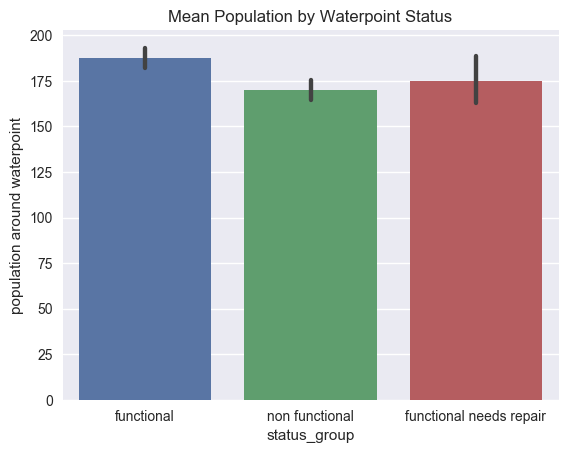

In [21]:
sns.barplot(df['status_group'],df['population'])
plt.title('Mean Population by Waterpoint Status')
plt.ylabel('population around waterpoint')
plt.show();

In [364]:
df.groupby(['status_group'])[['population']].describe()

population                                          \
                             count        mean         std  min  25%   50%   
status_group                                                                 
functional                 32259.0  187.553303  513.198991  0.0  0.0  40.0   
functional needs repair     4317.0  175.102154  433.033756  0.0  0.0  25.0   
non functional             22824.0  170.016430  413.094978  0.0  0.0   1.0   

                                         
                           75%      max  
status_group                             
functional               200.0  30500.0  
functional needs repair  245.0  15300.0  
non functional           230.0   9865.0

- Non functional waterpoints appear to have the lowest populations surrounding them. There doesn't appear to be a significant difference from needs repair waterpoints, but enough of a difference exists between them and functional ones.

### Recorded By
`recorded_by` - Group entering this row of data

In [276]:
df['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

### Scheme Management, Scheme Name
`scheme_management` - Who operates the waterpoint  
`scheme_name` - Who operates the waterpoint

In [37]:
print('unique scheme_management values:',len(df['scheme_management'].unique()))
print(df['scheme_management'].unique())

unique scheme_management: 13
['VWC' 'Other' nan 'Private operator' 'WUG' 'Water Board' 'WUA'
 'Water authority' 'Company' 'Parastatal' 'Trust' 'SWC' 'None']


In [38]:
print('unique scheme_name values:',len(df['scheme_name'].unique()))
print(df['scheme_name'].unique())

unique scheme_name values: 2697
['Roman' nan 'Nyumba ya mungu pipe scheme' ..., 'BL Nsherehehe'
 'Magati  gravity spri' 'Mtawanya']


In [39]:
scheme = df.groupby(['status_group','scheme_management'])[['id']].count().unstack()
scheme_pcts = scheme.apply(lambda x: x / x.sum(), axis=1)
scheme = pd.concat([scheme,scheme_pcts], axis=1)
scheme.columns = scheme.columns.droplevel()
scheme.iloc[:,12:].sort_values('functional', axis=1, ascending=False)

scheme_management,VWC,WUG,Water Board,WUA,Water authority,Parastatal,Private operator,Company,Other,Trust,SWC,None
status_group,,,,,,,,,,,,
functional,0.623972,0.098927,0.067564,0.065655,0.053248,0.031791,0.023991,0.017574,0.015073,0.001514,0.000658,0.000033
functional needs repair,0.570103,0.164143,0.027113,0.058378,0.109428,0.049340,0.005618,0.009038,0.005374,0.001221,0.000244,NaN
non functional,0.736539,0.072613,0.027753,0.030842,0.051656,0.024331,0.014779,0.023286,0.013591,0.000998,0.003612,NaN


In [40]:
scheme.iloc[:,:12]

scheme_management,Company,None,Other,Parastatal,Private operator,SWC,Trust,VWC,WUA,WUG,Water Board,Water authority
status_group,,,,,,,,,,,,
functional,534.0,1.0,458.0,966.0,729.0,20.0,46.0,18960.0,1995.0,3006.0,2053.0,1618.0
functional needs repair,37.0,NaN,22.0,202.0,23.0,1.0,5.0,2334.0,239.0,672.0,111.0,448.0
non functional,490.0,NaN,286.0,512.0,311.0,76.0,21.0,15499.0,649.0,1528.0,584.0,1087.0


### Permit

In [41]:
df['permit'].unique()

array([False, True, nan], dtype=object)

In [42]:
# how many permit nulls
df['permit'].isnull().sum()

3056

In [44]:
permit_status = df.groupby(['status_group','permit'])[['id']].count().unstack()
permit_status_pcts = permit_status.apply(lambda x: x / x.sum(), axis=1)
permit_status = pd.concat([permit_status,permit_status_pcts], axis=1)
permit_status.columns = ['False', 'True', '% False', '% True']
permit_status

,False,True,% False,% True
status_group,,,,
functional,9045,21541,0.295724,0.704276
functional needs repair,1320,2697,0.328603,0.671397
non functional,7127,14614,0.327814,0.672186


### Public Meeting

In [277]:
df['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [283]:
df.groupby(['public_meeting','status_group'])[['id']].count()

id
public_meeting status_group                  
False          functional                2173
               functional needs repair    442
               non functional            2440
True           functional               28408
               functional needs repair   3719
               non functional           18884

### Construction Year

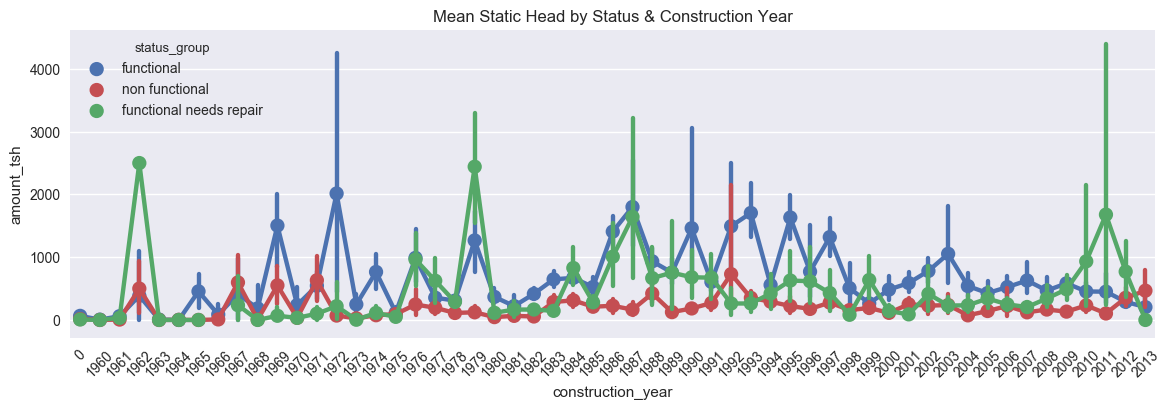

In [22]:
colors = sns.color_palette(palette='deep')
palette = {"functional":colors[0],
           "non functional":colors[2],
           "functional needs repair":colors[1]}

plt.figure(figsize=(14,4))
sns.pointplot(x='construction_year',y='amount_tsh',hue='status_group', palette=palette, data=df)
plt.title('Mean Static Head by Status & Construction Year')
plt.xticks(rotation=45)
plt.show();

- There are rows with 0 for construction year...

In [228]:
print('number of samples with invalid construction year: {:,}'.format(len(df[df['construction_year'] < 1900])))

number of samples with invalid construction year: 20,709


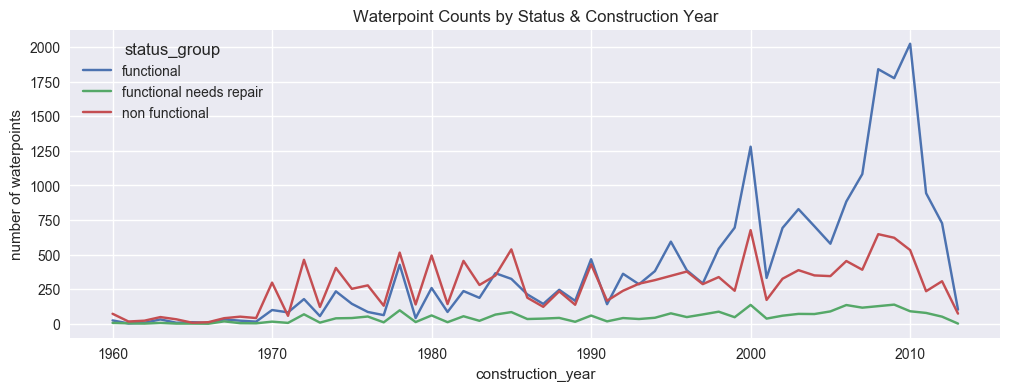

In [23]:
wps_by_cy = df[df['construction_year'] != 0].groupby(['construction_year','status_group']).count()['id'].unstack(fill_value=0)
wps_by_cy.plot(figsize=(12,4))
plt.title('Waterpoint Counts by Status & Construction Year')
plt.ylabel('number of waterpoints')
plt.show();

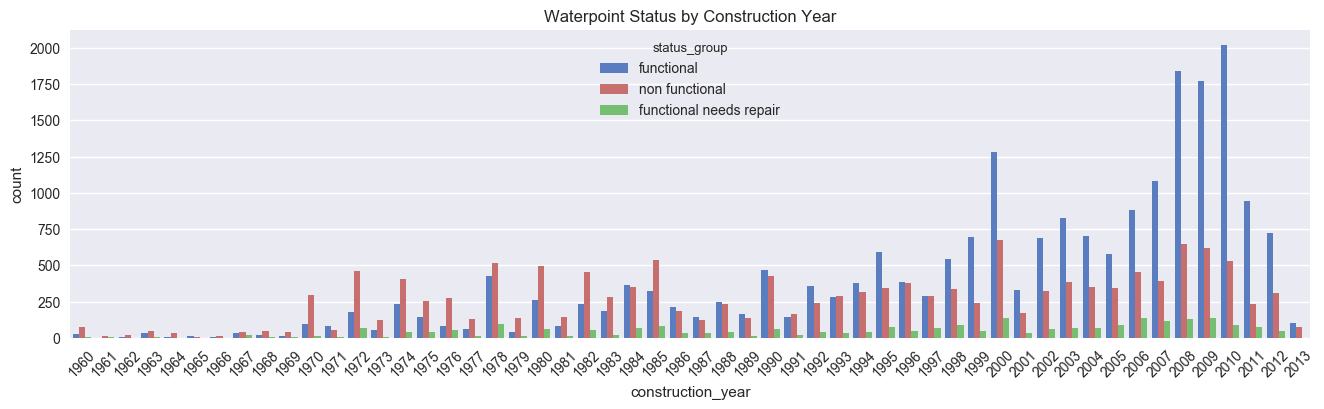

In [24]:
colors = sns.color_palette(palette='muted')
palette = {"functional":colors[0],
           "non functional":colors[2],
           "functional needs repair":colors[1]}

plt.figure(figsize=(16,4))
sns.countplot(x='construction_year', hue='status_group', palette=palette, data=df[df['construction_year'] != 0])
plt.xticks(rotation=45)
plt.title('Waterpoint Status by Construction Year')
plt.show();

### Extraction Type, Extraction Type Group, Extraction Type Class
`extraction_type` - The kind of extraction the waterpoint uses  
`extraction_type_group` - The kind of extraction the waterpoint uses  
`extraction_type_class` - The kind of extraction the waterpoint uses

In [47]:
print('unique extraction_type: {}'.format(df['extraction_type'].unique()))
print('\nunique extraction_type_group: {}'.format(df['extraction_type_group'].unique()))
print('\nunique extraction_type_class: {}'.format(df['extraction_type_class'].unique()))

unique extraction_type: ['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi'
 'other - mkulima/shinyanga']

unique extraction_type_group: ['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']

unique extraction_type_class: ['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']


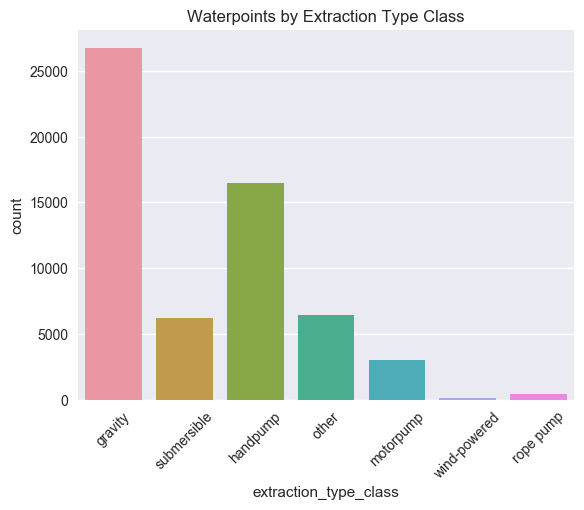

In [25]:
sns.countplot(df['extraction_type_class'])
plt.xticks(rotation=45)
plt.title('Waterpoints by Extraction Type Class')
plt.show();

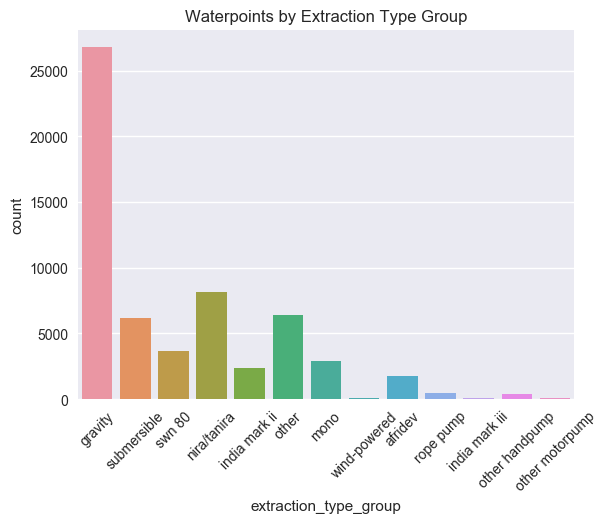

In [26]:
sns.countplot(df['extraction_type_group'])
plt.xticks(rotation=45)
plt.title('Waterpoints by Extraction Type Group')
plt.show();

In [50]:
# most frequent status for extraction type classes
df['status_group'].groupby(df['extraction_type_class']).describe()

,count,unique,top,freq
extraction_type_class,,,,
gravity,26780,3,functional,16048
handpump,16456,3,functional,10375
motorpump,2987,3,non functional,1714
other,6430,3,non functional,5195
rope pump,451,3,functional,293
submersible,6179,3,functional,3329
wind-powered,117,3,non functional,60


In [51]:
# amount_tsh (total static head) by extraction type class and status
df.groupby(['status_group','extraction_type_class'])['amount_tsh'].describe()

count        mean  \
status_group            extraction_type_class                        
functional              gravity                16048.0  555.427779   
                        handpump               10375.0  267.796627   
                        motorpump               1135.0  780.259912   
                        other                   1029.0  155.776482   
                        rope pump                293.0  242.081911   
                        submersible             3329.0  627.234980   
                        wind-powered              50.0    7.400000   
functional needs repair gravity                 2701.0  270.708256   
                        handpump                 995.0  306.874372   
                        motorpump                138.0    9.492754   
                        other                    206.0   98.058252   
                        rope pump                 17.0  305.882353   
                        submersible              253.0  354.407115   
                        wind-powered               7.0    7.142857   
non functional          gravity                 8031.0  172.044254   
                        handpump                5086.0  134.510224   
                        motorpump               1714.0   56.651109   
                        other                   5195.0   67.725736   
                        rope pump                141.0  110.638298   
                        submersible             2597.0  109.210243   
                        wind-powered              60.0   72.916667   

                                                        std  min  25%   50%  \
status_group            extraction_type_class                                 
functional              gravity                 3043.104445  0.0  0.0   0.0   
                        handpump                1477.572482  0.0  0.0   0.0   
                        motorpump              10958.377749  0.0  0.0   0.0   
                        other                   1669.194243  0.0  0.0   0.0   
                        rope pump                558.722338  0.0  0.0   0.0   
                        submersible             7289.141873  0.0  0.0  30.0   
                        wind-powered              22.090722  0.0  0.0   0.0   
functional needs repair gravity                  945.918808  0.0  0.0   0.0   
                        handpump                3303.133463  0.0  0.0   0.0   
                        motorpump                 23.655757  0.0  0.0   0.0   
                        other                    540.614931  0.0  0.0   0.0   
                        rope pump               1210.614817  0.0  0.0   0.0   
                        submersible             3230.747838  0.0  0.0  20.0   
                        wind-powered              18.898224  0.0  0.0   0.0   
non functional          gravity                 1632.239867  0.0  0.0   0.0   
                        handpump                 721.712978  0.0  0.0   0.0   
                        motorpump                758.060857  0.0  0.0   0.0   
                        other                    463.810202  0.0  0.0   0.0   
                        rope pump                499.242587  0.0  0.0   0.0   
                        submersible              855.563959  0.0  0.0   0.0   
                        wind-powered             232.753036  0.0  0.0   0.0   

                                                 75%       max  
status_group            extraction_type_class                   
functional              gravity                300.0  120000.0  
                        handpump                 0.0  100000.0  
                        motorpump               50.0  350000.0  
                        other                    0.0   50000.0  
                        rope pump              300.0    5000.0  
                        submersible             50.0  250000.0  
                        wind-powered             0.0     100.0  
functional needs repair gravity    

In [52]:
# breakdown of status by extraction type classes
extract_type_status = df.groupby(['extraction_type_class','status_group']).size().unstack(fill_value=0)
extract_type_status['total'] = extract_type_status['functional'] + extract_type_status['functional needs repair'] + extract_type_status['non functional']
extract_type_status['% functional'] = extract_type_status['functional'] / extract_type_status['total']
extract_type_status['% needs repair'] = extract_type_status['functional needs repair'] / extract_type_status['total']
extract_type_status['% non functional'] = extract_type_status['non functional'] / extract_type_status['total']
extract_type_status

status_group,functional,functional needs repair,non functional,total,% functional,% needs repair,% non functional
extraction_type_class,,,,,,,
gravity,16048,2701,8031,26780,0.599253,0.100859,0.299888
handpump,10375,995,5086,16456,0.630469,0.060464,0.309067
motorpump,1135,138,1714,2987,0.379980,0.046200,0.573820
other,1029,206,5195,6430,0.160031,0.032037,0.807932
rope pump,293,17,141,451,0.649667,0.037694,0.312639
submersible,3329,253,2597,6179,0.538760,0.040945,0.420295
wind-powered,50,7,60,117,0.427350,0.059829,0.512821


Bins to try
- Mode of "functional": gravity, handpump, rope pump
- Mode of "non functional": motorpump, other
- Mode of "functional needs repair": 

In [53]:
# which types are above the mean of % needs repair for all extraction types?
extraction_needs_repair_mean = extract_type_status['% needs repair'].mean()
extract_type_status[extract_type_status['% needs repair'] >= extraction_needs_repair_mean]

status_group,functional,functional needs repair,non functional,total,% functional,% needs repair,% non functional
extraction_type_class,,,,,,,
gravity,16048,2701,8031,26780,0.599253,0.100859,0.299888
handpump,10375,995,5086,16456,0.630469,0.060464,0.309067
wind-powered,50,7,60,117,0.427350,0.059829,0.512821


In [54]:
# which extraction types have more than 50% non functional?
extract_type_status[extract_type_status['% non functional'] >= .5]

status_group,functional,functional needs repair,non functional,total,% functional,% needs repair,% non functional
extraction_type_class,,,,,,,
motorpump,1135,138,1714,2987,0.379980,0.046200,0.573820
other,1029,206,5195,6430,0.160031,0.032037,0.807932
wind-powered,50,7,60,117,0.427350,0.059829,0.512821


- Perhaps it's worth combining the type classes into a smaller number, based on energy source
  - nature-powered
  - human-powered
  - motor-powered
- Of the total 4,317 waterpoints that need repair, 62% are gravity and 85% are gravity or handpump extraction types.
- Are there any similarities between the needs repair and non-functional waterpoints?

### Management, Management Group
`management` - How the waterpoint is managed  
`management_group` - How the waterpoint is managed

In [56]:
print('unique management values:',df['management'].unique(),'\n')
print('unique management_group values:',df['management_group'].unique())

unique management values: ['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust'] 

unique management_group values: ['user-group' 'other' 'commercial' 'parastatal' 'unknown']


In [57]:
mgmt_group_status = df.groupby(['management_group','status_group'])[['id']].count().unstack()
mgmt_group_status.columns = mgmt_group_status.columns.droplevel()
mgmt_group_status['total'] = mgmt_group_status['functional'] + mgmt_group_status['functional needs repair'] + mgmt_group_status['non functional']
mgmt_group_status['% functional'] = mgmt_group_status['functional'] / mgmt_group_status['total']
mgmt_group_status['% needs repair'] = mgmt_group_status['functional needs repair'] / mgmt_group_status['total']
mgmt_group_status['% non functional'] = mgmt_group_status['non functional'] / mgmt_group_status['total']
mgmt_group_status.sort_values('% functional', ascending=False)

status_group,functional,functional needs repair,non functional,total,% functional,% needs repair,% non functional
management_group,,,,,,,
commercial,2235,117,1286,3638,0.614349,0.032161,0.353491
parastatal,1020,211,537,1768,0.576923,0.119344,0.303733
other,528,56,359,943,0.559915,0.059385,0.380700
user-group,28252,3906,20332,52490,0.538236,0.074414,0.387350
unknown,224,27,310,561,0.399287,0.048128,0.552585


### Water Quality, Quality Group
`water_quality` - The quality of the water  
`quality_group` - The quality of the water

In [157]:
df['water_quality'].unique()

array(['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured',
       'salty abandoned', 'fluoride abandoned'], dtype=object)

In [158]:
df['quality_group'].unique()

array(['good', 'salty', 'milky', 'unknown', 'fluoride', 'colored'], dtype=object)

In [159]:
quality_status = df.groupby(['quality_group','status_group']).size().unstack(fill_value=0)
quality_status['total'] = quality_status['functional'] + quality_status['functional needs repair'] + quality_status['non functional']
quality_status['% functional'] = quality_status['functional'] / quality_status['total']
quality_status['% needs repair'] = quality_status['functional needs repair'] / quality_status['total']
quality_status['% non functional'] = quality_status['non functional'] / quality_status['total']
quality_status.sort_values('% functional', ascending=False)

status_group,functional,functional needs repair,non functional,total,% functional,% needs repair,% non functional
quality_group,,,,,,,
fluoride,157,13,47,217,0.723502,0.059908,0.216590
good,28760,3904,18154,50818,0.565941,0.076823,0.357236
milky,438,14,352,804,0.544776,0.017413,0.437811
colored,246,54,190,490,0.502041,0.110204,0.387755
salty,2394,297,2504,5195,0.460828,0.057170,0.482002
unknown,264,35,1577,1876,0.140725,0.018657,0.840618


### Quantity, Quantity Group
`quantity` - The quantity of water  
`quantity_group` - The quantity of water

In [36]:
df.groupby('status_group')['quantity'].value_counts()

status_group             quantity    
functional               enough          21648
                         insufficient     7916
                         seasonal         2325
                         unknown           213
                         dry               157
functional needs repair  enough           2400
                         insufficient     1450
                         seasonal          416
                         dry                37
                         unknown            14
non functional           enough           9138
                         dry              6052
                         insufficient     5763
                         seasonal         1309
                         unknown           562
Name: quantity, dtype: int64

In [37]:
df.groupby('status_group')['quantity'].value_counts().ravel() == df.groupby('status_group')['quantity_group'].value_counts().ravel()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True], dtype=bool)

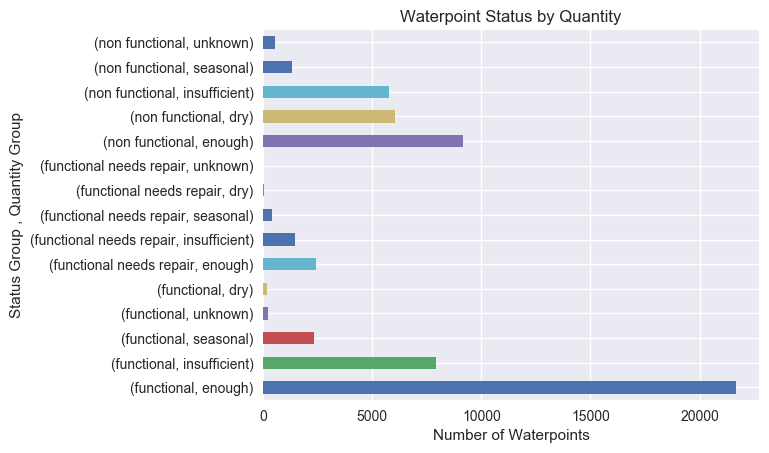

In [27]:
df.groupby('status_group')['quantity_group'].value_counts().plot('barh')
plt.xlabel('Number of Waterpoints')
plt.ylabel('Status Group , Quantity Group')
plt.title('Waterpoint Status by Quantity')
plt.show();

In [39]:
print('unique values for quantity:',df['quantity'].unique())
print('unique values for quantity_group:',df['quantity_group'].unique())

unique values for quantity: ['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
unique values for quantity_group: ['enough' 'insufficient' 'dry' 'seasonal' 'unknown']


- There doesn't appear to be any difference between `quantity` and `quantity_group`
- However, it's suspicious that there are "non functional" waterpoints with "enough" water
  - The non functional class comprises 38% of the training samples, so creating a good signal for this is critical
  - Look at `quantity` vs `amount_tsh` as a new feature to engineer

In [ ]:
# PLOT QUANTITY VS. AMOUNT TSH --> LIKELY TO CARRY A LOT OF SIGNAL

### Source, Source Type, Source Class
`source` - The source of the water  
`source_type` - The source of the water  
`source_class` - The source of the water

In [139]:
df['source'].unique()

array(['spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other',
       'shallow well', 'river', 'hand dtw', 'lake', 'unknown'], dtype=object)

In [140]:
df['source_type'].unique()

array(['spring', 'rainwater harvesting', 'dam', 'borehole', 'other',
       'shallow well', 'river/lake'], dtype=object)

In [141]:
df['source_class'].unique()

array(['groundwater', 'surface', 'unknown'], dtype=object)

In [156]:
sources_status = df.groupby(['source_type','status_group']).size().unstack(fill_value=0)
sources_status['total'] = sources_status['functional'] + sources_status['functional needs repair'] + sources_status['non functional']
sources_status['% functional'] = sources_status['functional'] / sources_status['total']
sources_status['% needs repair'] = sources_status['functional needs repair'] / sources_status['total']
sources_status['% non functional'] = sources_status['non functional'] / sources_status['total']
sources_status.sort_values('% functional', ascending=False)

status_group,functional,functional needs repair,non functional,total,% functional,% needs repair,% non functional
source_type,,,,,,,
spring,10592,1276,5153,17021,0.622290,0.074966,0.302744
rainwater harvesting,1386,314,595,2295,0.603922,0.136819,0.259259
other,158,5,115,278,0.568345,0.017986,0.413669
river/lake,5627,1233,3517,10377,0.542257,0.118820,0.338923
borehole,5919,508,5522,11949,0.495355,0.042514,0.462131
shallow well,8324,957,7543,16824,0.494769,0.056883,0.448348
dam,253,24,379,656,0.385671,0.036585,0.577744


In [146]:
sources_status.sort_values('% functional', ascending=False).head(4).index

Index(['spring', 'rainwater harvesting', 'other', 'river/lake'], dtype='object', name='source_type')

### Waterpoint Type, Waterpoint Type Group
`waterpoint_type` - The kind of waterpoint  
`waterpoint_type_group` - The kind of waterpoint

In [74]:
print('unique waterpoint_type: {}'.format(df['waterpoint_type'].unique()))
print('\nunique waterpoint_type_group: {}'.format(df['waterpoint_type_group'].unique()))

unique waterpoint_type: ['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']

unique waterpoint_type_group: ['communal standpipe' 'hand pump' 'other' 'improved spring' 'cattle trough'
 'dam']


In [75]:
# breakdown of status by waterpoint type groups
wp_type_status = df.groupby(['waterpoint_type_group','status_group']).size().unstack(fill_value=0)
wp_type_status['total'] = wp_type_status['functional'] + wp_type_status['functional needs repair'] + wp_type_status['non functional']
wp_type_status['% functional'] = wp_type_status['functional'] / wp_type_status['total']
wp_type_status['% needs repair'] = wp_type_status['functional needs repair'] / wp_type_status['total']
wp_type_status['% non functional'] = wp_type_status['non functional'] / wp_type_status['total']
wp_type_status

status_group,functional,functional needs repair,non functional,total,% functional,% needs repair,% non functional
waterpoint_type_group,,,,,,,
cattle trough,84,2,30,116,0.724138,0.017241,0.258621
communal standpipe,19961,2908,11756,34625,0.576491,0.083986,0.339523
dam,6,0,1,7,0.857143,0.000000,0.142857
hand pump,10805,1029,5654,17488,0.617852,0.058840,0.323307
improved spring,563,85,136,784,0.718112,0.108418,0.173469
other,840,293,5247,6380,0.131661,0.045925,0.822414


# Baseline Models

## One Numeric Feature

In [28]:
df = load_training_data()

x = df['amount_tsh']
y = df['status_group']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=37)

logreg = LogisticRegression(random_state=37)
lr_cv_scores = cross_val_score(logreg, x_train.values.reshape(-1,1), y_train, cv=5)
print('Logistic Regression accuracy scores by fold: {}'.format(lr_cv_scores))
print('Mean 5-fold CV accuracy for Logistic Regression = {:0.3f}'.format(lr_cv_scores.mean()))

Logistic Regression accuracy scores by fold: [ 0.54190213  0.54190213  0.54196729  0.54203247  0.54203247]
Mean 5-fold CV accuracy for Logistic Regression = 0.542


## Four Numeric Features

In [29]:
df = load_training_data()

numeric_cols = ['amount_tsh','gps_height','population','construction_year']

x = df[numeric_cols]
y = df['status_group']
print('x shape = {}\ny shape = {}'.format(x.shape,y.shape))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=37)
print('\nx_train shape = {}\ny_train shape = {}'.format(x_train.shape,y_train.shape))
print('\nx_test shape = {}\ny_test shape = {}'.format(x_test.shape,y_test.shape))

x shape = (59400, 4)
y shape = (59400,)

x_train shape = (41580, 4)
y_train shape = (41580,)

x_test shape = (17820, 4)
y_test shape = (17820,)


### K Nearest Neighbors

In [31]:
knn_cv_scores = {}

for k in range(1,41):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_cv_scores[k] = np.mean(cross_val_score(knn, x_train[numeric_cols], y_train, cv=5))

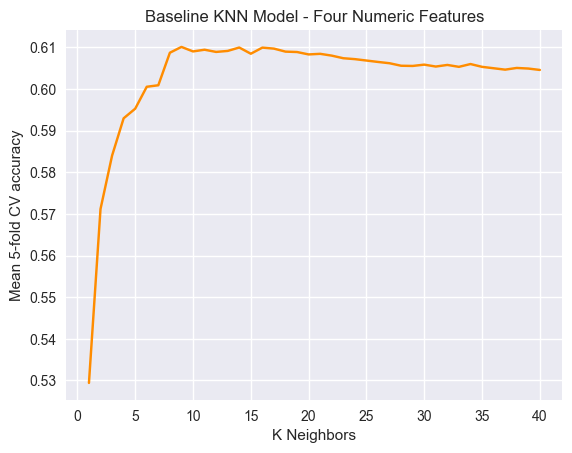

In [32]:
lists = sorted(knn_cv_scores.items()) # sorted by key, return a list of tuples
k_neighbors, k_accuracy = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(k_neighbors, k_accuracy, color='darkorange')
plt.xlabel('K Neighbors')
plt.ylabel('Mean 5-fold CV accuracy')
plt.title('Baseline KNN Model - Four Numeric Features')
plt.show();

In [34]:
max(k_accuracy)

0.61012510188405211

### Logistic Regression

In [35]:
logreg = LogisticRegression(random_state=37)
lr_cv_scores = cross_val_score(logreg, x_train[numeric_cols], y_train, cv=5)
print('Logistic Regression accuracy scores by fold: {}'.format(lr_cv_scores))
print('Mean 5-fold CV accuracy for Logistic Regression = {:0.3f}'.format(lr_cv_scores.mean()))

Logistic Regression accuracy scores by fold: [ 0.54118071  0.53601058  0.54244829  0.54287432  0.53289236]
Mean 5-fold CV accuracy for Logistic Regression = 0.539


### Random Forest

In [36]:
rf = RandomForestClassifier(n_estimators=500, max_depth=12, bootstrap=True, min_samples_leaf=5, n_jobs=-1)
rf_cv_scores = cross_val_score(rf, x_train[numeric_cols], y_train, cv=5)
print('Random Forest accuracy scores by fold: {}'.format(rf_cv_scores))
print('Mean 5-fold CV accuracy for Random Forest = {:0.3f}'.format(rf_cv_scores.mean()))

Random Forest accuracy scores by fold: [ 0.64205843  0.64229891  0.64442039  0.64269393  0.63800361]
Mean 5-fold CV accuracy for Random Forest = 0.642


- 19% better, but still a lot of room from improvement

# Feature Engineering

## Create Dummy Variables

In [37]:
def add_dummies(df,cols_to_dummy,dummies_to_keep,non_dummy_cols):
    """Append list of categorical features as dummies to dataframe,
    keeping only the provided list of non-dummy/continuous variables
    plus newly created dummies."""
    dummies = pd.get_dummies(df[cols_to_dummy]) #district_code
    new_df = pd.concat([df[non_dummy_cols], dummies[dummies_to_keep]], axis=1)
    return new_df

### Evaluate

In [ ]:
x = pd.concat([df[numeric_cols], dummies], axis=1) # dummies = 4,108 dummies from 12 categorical
y = df['status_group']
print('x shape = {}\ny shape = {}'.format(x.shape,y.shape))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=37)
print('\nx_train shape = {}\ny_train shape = {}'.format(x_train.shape,y_train.shape))
print('\nx_test shape = {}\ny_test shape = {}'.format(x_test.shape,y_test.shape))

In [46]:
# 4,112 total features (4,108 dummies from 12 categorical)
rf = RandomForestClassifier(n_estimators=500, max_depth=12, bootstrap=True, min_samples_leaf=5, n_jobs=-1)
rf_cv_scores = cross_val_score(rf, x_train, y_train, cv=5)
print('Random Forest accuracy scores by fold: {}'.format(rf_cv_scores))
print('Mean 5-fold CV accuracy for Random Forest = {:0.3f}'.format(rf_cv_scores.mean()))

Random Forest accuracy scores by fold: [ 0.69604425  0.69784778  0.7017797   0.69693325  0.69284426]
Mean 5-fold CV accuracy for Random Forest = 0.697


In [47]:
# what are the top 20 features by "importance"?
def getValue(item):
    return item[1]

rf.fit(x_train,y_train)

feat_imp_20 = sorted(list(zip(x_train.columns,rf.feature_importances_)),key=getValue,reverse=True)[:20]
for idx,fi in enumerate(feat_imp_20): print(idx+1,fi)

1 ('quantity_group_dry', 0.11697326704694665)
2 ('extraction_type_class_other', 0.087675291866334645)
3 ('waterpoint_type_group_other', 0.078609491748062699)
4 ('quantity_group_enough', 0.06419494971546244)
5 ('construction_year', 0.052091337866727351)
6 ('amount_tsh', 0.051136892195294957)
7 ('quality_group_unknown', 0.030793163564260099)
8 ('gps_height', 0.024716623450835092)
9 ('extraction_type_class_gravity', 0.023716390514663527)
10 ('funder_Government Of Tanzania', 0.021809848822236886)
11 ('extraction_type_class_handpump', 0.020736602193518753)
12 ('population', 0.02018664726412785)
13 ('region_Iringa', 0.01958675341288698)
14 ('waterpoint_type_group_communal standpipe', 0.017834530799139874)
15 ('waterpoint_type_group_hand pump', 0.017581717779905214)
16 ('quality_group_good', 0.015535562112231369)
17 ('basin_Ruvuma / Southern Coast', 0.015303446616178561)
18 ('region_Lindi', 0.009025612316453312)
19 ('region_Mtwara', 0.0087666814063832761)
20 ('extraction_type_class_motorpump'

## run the model again with only these 20 features

In [ ]:
imp_cols_20 = [item[0] for item in feat_imp_20]

rf_cv_scores = cross_val_score(rf, x_train[imp_cols_20], y_train, cv=5)
print('Random Forest accuracy scores by fold: {}'.format(rf_cv_scores))
print('Mean 5-fold CV accuracy for Random Forest = {:0.3f}'.format(rf_cv_scores.mean()))

## Convert Latitude / Longitude
"Lat long coordinates have a problem that they are 2 features that represent a three dimensional space. This means that the long coordinate goes all around, which means the two most extreme values are actually very close together. I've dealt with this problem a few times and what I do in this case is map them to x, y and z coordinates. This means close points in these 3 dimensions are also close in reality. Depending on the use case you can disregard the changes in height and map them to a perfect sphere. These features can then be standardized properly."

```python
x = cos(lat) * cos(lon)
y = cos(lat) * sin(lon)
z = sin(lat)
```

Source: https://datascience.stackexchange.com/questions/13567/ways-to-deal-with-longitude-latitude-feature

In [39]:
def convert_lat_lon(df,lat_col='latitude',lon_col='longitude'):
    df['x'] = np.cos(df[lat_col]) * np.cos(df[lon_col])
    df['y'] = np.cos(df[lat_col]) * np.sin(df[lon_col])
    df['z'] = np.sin(df[lat_col])

In [40]:
convert_lat_lon(df)
df.iloc[:5,40:]

,status_group,x,y,z
0,functional,0.843332,0.337399,0.418274
1,functional,0.539805,0.076757,-0.838283
2,functional,-0.755733,0.183697,0.628588
3,non functional,0.112276,0.112647,0.987271
4,functional,-0.241658,0.070821,-0.967774


### Evaluate

In [ ]:
x = pd.concat([pd.concat([df, dummies], axis=1)[imp_cols_20],df[['x','y','z']]], axis=1)
y = df['status_group']
print('x shape = {}\ny shape = {}'.format(x.shape,y.shape))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=37)
print('\nx_train shape = {}\ny_train shape = {}'.format(x_train.shape,y_train.shape))
print('\nx_test shape = {}\ny_test shape = {}'.format(x_test.shape,y_test.shape))

In [52]:
# 20 "most important" features + x, y, and z
rf = RandomForestClassifier(n_estimators=500, max_depth=12, bootstrap=True, min_samples_leaf=5, n_jobs=-1)
rf_cv_scores = cross_val_score(rf, x_train, y_train, cv=5)
print('Random Forest accuracy scores by fold: {}'.format(rf_cv_scores))
print('Mean 5-fold CV accuracy for Random Forest = {:0.3f}'.format(rf_cv_scores.mean()))

Random Forest accuracy scores by fold: [ 0.7555609   0.7606108   0.76118326  0.75225496  0.74984967]
Mean 5-fold CV accuracy for Random Forest = 0.756


## Deal with Class Imbalance
### Class Weights

In [97]:
# search through a bunch of class weights to find optimal ratio

#for repair in np.arange(.45,.6,.05):
repair = .45  # round(repair,3)
nonfunc = np.round(np.arange(.1,.45,.05),3)
func = np.round([1-repair-x for x in nonfunc],3)
print('Weights to try:')
print('{:>28} {}'.format('functional needs repair ',repair))
print('{:>28} {}'.format('non functional ',nonfunc))
print('{:>28} {}'.format('functional ',func))
weights = np.round(list(zip(nonfunc,func)),3)

print('Results:')
for nf, f in weights:
    rf = RandomForestClassifier(class_weight={'functional needs repair': repair, 'non functional': nf, 'functional': f},
                                n_estimators=500, max_depth=12, bootstrap=True, min_samples_leaf=5, n_jobs=-1)
    rf_cv_scores = cross_val_score(rf, x_train, y_train, cv=5)
    print('nonfunc {:0.3f} func {:0.3f}, mean 5-fold CV accuracy = {:0.3f}'.format(nf,f,rf_cv_scores.mean()))
print('\n')

Weights to try:
    functional needs repair  0.45
             non functional  [ 0.1   0.15  0.2   0.25  0.3   0.35  0.4 ]
                 functional  [ 0.45  0.4   0.35  0.3   0.25  0.2   0.15]
Results:
nonfunc 0.100 func 0.450, mean 5-fold CV accuracy = 0.712
nonfunc 0.150 func 0.400, mean 5-fold CV accuracy = 0.726
nonfunc 0.200 func 0.350, mean 5-fold CV accuracy = 0.738
nonfunc 0.250 func 0.300, mean 5-fold CV accuracy = 0.751
nonfunc 0.300 func 0.250, mean 5-fold CV accuracy = 0.762
nonfunc 0.350 func 0.200, mean 5-fold CV accuracy = 0.754
nonfunc 0.400 func 0.150, mean 5-fold CV accuracy = 0.702




- After cross validation of 343 weights&mdash;7 for each class&mdash;highest accuracy was found with 45% functional needs repair (the minority class), 30% non functional (second in class frequency), and 25% functional (majority class).

# Data Preparation & Cross Validatation

In [41]:
def label_tsh_quantity(row):
    if (row['amount_tsh'] <= 300) & (row['quantity'] != 'enough'):
        return 0
    else:
        return 1
    
def label_tsh_population(row):
    if (row['amount_tsh'] <= 275) & (row['population'] < 176):
        return 0
    else:
        return 1

def prepare_cols(df):
    df['district_code'] = df['district_code'].astype(str)
    
    non_dummy_cols = ['tsh_vs_population','tsh_vs_quantity','public_meeting','permit','amount_tsh',
                      'gps_height','population','construction_year','x','y','z']

    cols_to_dummy = ['extraction_type_class','waterpoint_type_group','quantity_group',
                     'quality_group','source_type','region','basin','funder','scheme_management',
                     'management_group','installer','district_code']

    dummified_names = {}
    for feature in cols_to_dummy: # use this section to customize how many dummies from each feature are modeled
        if feature == 'funder':
            dummified_names[feature] = ['Government Of Tanzania','Danida','Hesawa','Rwssp','World Bank']
        elif feature == 'scheme_management':
            dummified_names[feature] = ['VWC','WUG','Water authority']
        elif feature == 'installer':
            dummified_names[feature] = ['DWE', 'Government', 'RWE', 'Commu', 'DANIDA']
        elif feature == 'district_code':
            dummified_names[feature] = [33, 53, 13, 43, 6, 3, 5, 8, 1]
        else:
            dummified_names[feature] = df[feature].unique() # use all unique dummies created for each feature
        dummified_names[feature] = [str(feature)+'_'+str(x) for x in dummified_names[feature]] # prepend feature group name
    dummies_to_keep = list(dummified_names.values())
    dummies_to_keep = [item for sublist in dummies_to_keep for item in sublist] # unpack list of lists
    df['permit'] = df['permit'].factorize()[0]
    df['public_meeting'] = df['public_meeting'].factorize()[0]
    df['tsh_vs_quantity'] = df.apply(lambda row: label_tsh_quantity(row), axis=1)
    df['tsh_vs_population'] = df.apply(lambda row: label_tsh_population(row), axis=1)
    print('Number of dummies to use: {}'.format(len(dummies_to_keep)))
    return non_dummy_cols, cols_to_dummy, dummies_to_keep

In [42]:
df = load_training_data()

In [43]:
non_dummy_cols, cols_to_dummy, dummies_to_keep = prepare_cols(df)

Number of dummies to use: 88


In [372]:
non_dummy_cols

['tsh_vs_population',
 'tsh_vs_quantity',
 'public_meeting',
 'permit',
 'amount_tsh',
 'gps_height',
 'population',
 'construction_year',
 'x',
 'y',
 'z']

In [373]:
dummies_to_keep

['district_code_33',
 'district_code_53',
 'district_code_13',
 'district_code_43',
 'district_code_6',
 'district_code_3',
 'district_code_5',
 'district_code_8',
 'district_code_1',
 'region_Iringa',
 'region_Mara',
 'region_Manyara',
 'region_Mtwara',
 'region_Kagera',
 'region_Tanga',
 'region_Shinyanga',
 'region_Tabora',
 'region_Pwani',
 'region_Ruvuma',
 'region_Kilimanjaro',
 'region_Rukwa',
 'region_Mwanza',
 'region_Kigoma',
 'region_Lindi',
 'region_Dodoma',
 'region_Arusha',
 'region_Mbeya',
 'region_Singida',
 'region_Morogoro',
 'region_Dar es Salaam',
 'extraction_type_class_gravity',
 'extraction_type_class_submersible',
 'extraction_type_class_handpump',
 'extraction_type_class_other',
 'extraction_type_class_motorpump',
 'extraction_type_class_wind-powered',
 'extraction_type_class_rope pump',
 'funder_Government Of Tanzania',
 'funder_Danida',
 'funder_Hesawa',
 'funder_Rwssp',
 'funder_World Bank',
 'quality_group_good',
 'quality_group_salty',
 'quality_group_milk

In [374]:
cols_to_dummy

['extraction_type_class',
 'waterpoint_type_group',
 'quantity_group',
 'quality_group',
 'source_type',
 'region',
 'basin',
 'funder',
 'scheme_management',
 'management_group',
 'installer',
 'district_code']

## Engineer features and train/test split

In [56]:
convert_lat_lon(df) # adds x, y, and z columns
x = add_dummies(df,cols_to_dummy,dummies_to_keep,non_dummy_cols) # keeps only the specified columns from above
y = df['status_group']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=37)
print('x_train shape = {} \t y_train shape = {}'.format(x_train.shape,y_train.shape))
print('x_test shape = {} \t y_test shape = {}'.format(x_test.shape,y_test.shape))

x_train shape = (41580, 99) 	 y_train shape = (41580,)
x_test shape = (17820, 99) 	 y_test shape = (17820,)


In [57]:
print('ensure true/false columns were factorized:')
print('permit:',df['permit'].unique())
print('public_meeting:',df['public_meeting'].unique())
print('tsh_vs_quantity:',df['tsh_vs_quantity'].unique())
print('tsh_vs_population:',df['tsh_vs_population'].unique())

ensure true/false columns were factorized:
permit: [ 0  1 -1]
public_meeting: [ 0 -1  1]
tsh_vs_quantity: [1 0]
tsh_vs_population: [1 0]


## Get CV Scores

### Weighted

In [378]:
rf = RandomForestClassifier(class_weight={'functional': .25, 'non functional': .3, 'functional needs repair': .45}, 
                            n_estimators=1000, max_depth=None, bootstrap=True, min_samples_leaf=3, n_jobs=-1)
model = rf
cv_scores = {}
cv_scores['accuracy'] = cross_val_score(model, x_train, y_train, cv=5)
cv_scores['precision'] = cross_val_score(model, x_train, y_train, cv=5,
                                         scoring=make_scorer(precision_score, average='weighted'))
cv_scores['recall'] = cross_val_score(model, x_train, y_train, cv=5,
                                      scoring=make_scorer(recall_score, average='weighted'))
cv_scores['f1'] = cross_val_score(model, x_train, y_train, cv=5,
                                  scoring=make_scorer(f1_score, average='weighted'))

for key,value in sorted(cv_scores.items()):
    if key == 'accuracy':
        print(key.upper())
    else:
        print(key.upper(),'WEIGHTED')
    print('\tmean: {:0.3f}'.format(value.mean()))
    print('\tby fold:',value)

ACCURACY
	mean: 0.797
	by fold: [ 0.8   0.8   0.8   0.8   0.79]
F1 WEIGHTED
	mean: 0.791
	by fold: [ 0.79  0.79  0.79  0.79  0.79]
PRECISION WEIGHTED
	mean: 0.792
	by fold: [ 0.8   0.79  0.79  0.79  0.79]
RECALL WEIGHTED
	mean: 0.797
	by fold: [ 0.8   0.8   0.8   0.8   0.79]


### Macro

In [379]:
rf = RandomForestClassifier(class_weight={'functional': .25, 'non functional': .3, 'functional needs repair': .45}, 
                            n_estimators=1000, max_depth=None, bootstrap=True, min_samples_leaf=3, n_jobs=-1)
model = rf
cv_scores = {}
cv_scores['accuracy'] = cross_val_score(model, x_train, y_train, cv=5)
cv_scores['precision'] = cross_val_score(model, x_train, y_train, cv=5,
                                         scoring=make_scorer(precision_score, average='macro'))
cv_scores['recall'] = cross_val_score(model, x_train, y_train, cv=5,
                                      scoring=make_scorer(recall_score, average='macro'))
cv_scores['f1'] = cross_val_score(model, x_train, y_train, cv=5,
                                  scoring=make_scorer(f1_score, average='macro'))

for key,value in sorted(cv_scores.items()):
    if key == 'accuracy':
        print(key.upper())
    else:
        print(key.upper(),'MACRO')
    print('\tmean: {:0.3f}'.format(value.mean()))
    print('\tby fold:',value)

ACCURACY
	mean: 0.797
	by fold: [ 0.8   0.8   0.8   0.8   0.79]
F1 MACRO
	mean: 0.679
	by fold: [ 0.68  0.68  0.68  0.68  0.68]
PRECISION MACRO
	mean: 0.722
	by fold: [ 0.74  0.71  0.72  0.72  0.72]
RECALL MACRO
	mean: 0.658
	by fold: [ 0.66  0.66  0.66  0.66  0.66]


## ROC / AUC

In [58]:
y_train_bin = label_binarize(y_train, classes=['functional','non functional','functional needs repair'])
n_classes = y_train_bin.shape[1]
xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train_bin, test_size=.3, random_state=37)

In [59]:
rf = RandomForestClassifier(class_weight=[{0: 1, 1: .25}, {0: 1, 1: .3}, {0: 1, 1: .45}],
                            n_estimators=1000, max_depth=None, bootstrap=True, min_samples_leaf=3, n_jobs=-1)
y_score = rf.fit(xx_train, yy_train).predict_proba(xx_test)

In [60]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yy_test[:, i], y_score[i][:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

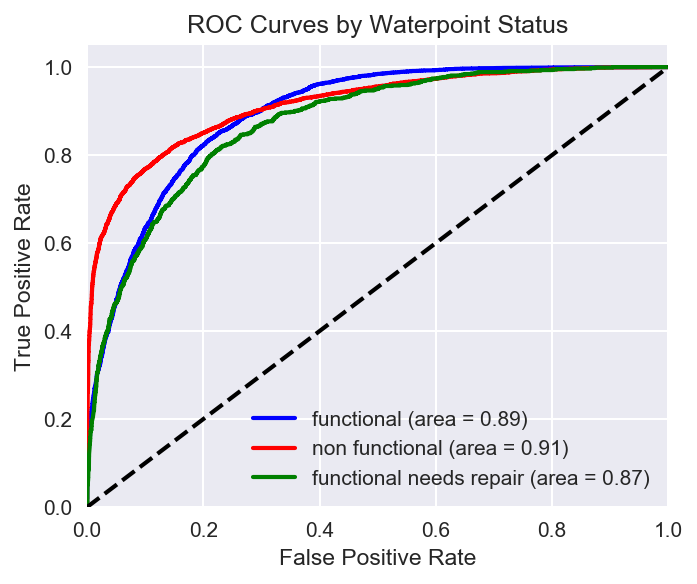

In [64]:
# Plot of a ROC curve for a specific class (0: functional, 1: non functional, 2: functional needs repair)
plt.figure(figsize=(5,4),dpi=150)
lw = 2
plt.plot(fpr[0], tpr[0], color='blue',
         lw=lw, label='functional (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='non functional (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='green',
         lw=lw, label='functional needs repair (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Waterpoint Status')
plt.legend(loc='best')
plt.show();

## Confusion Matrix

In [65]:
class_names = ['functional','functional needs repair','non functional']

xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train, test_size=.3, random_state=37)
print('xx_test shape:',xx_test.shape,'yy_test shape:',yy_test.shape)

xx_test shape: (12474, 99) yy_test shape: (12474,)


In [66]:
yy_test.value_counts()

functional                 6819
non functional             4771
functional needs repair     884
Name: status_group, dtype: int64

In [67]:
rf = RandomForestClassifier(class_weight={'functional': .25, 'non functional': .3, 'functional needs repair': .45},
                            n_estimators=1000, max_depth=None, bootstrap=True, min_samples_leaf=3, n_jobs=-1)

y_pred = rf.fit(xx_train, yy_train).predict(xx_test)

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[6071  194  554]
 [ 456  289  139]
 [1140   45 3586]]
Normalized confusion matrix
[[ 0.89  0.03  0.08]
 [ 0.52  0.33  0.16]
 [ 0.24  0.01  0.75]]


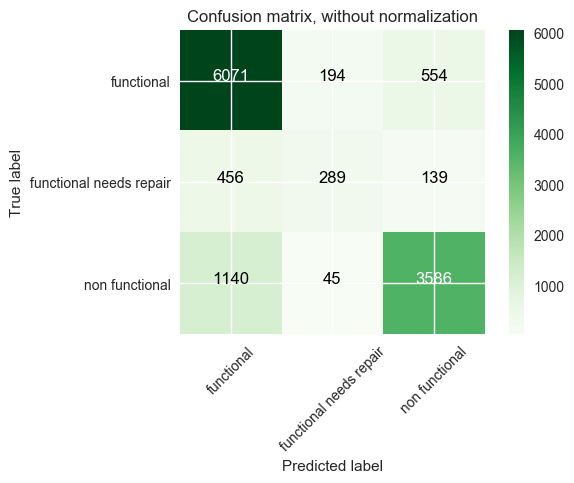

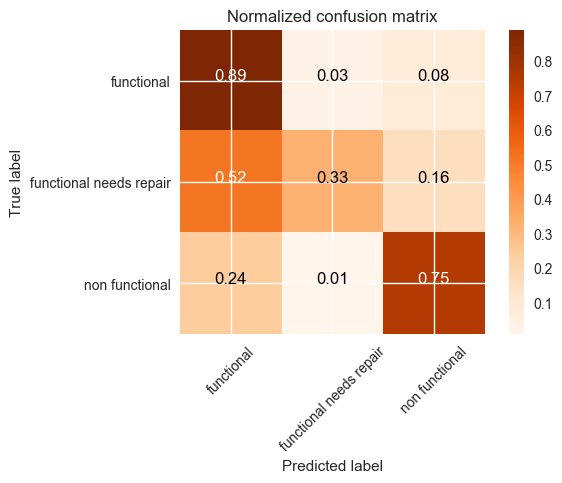

In [70]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(yy_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization', cmap=plt.cm.Greens)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix', cmap=plt.cm.Oranges)

plt.show();

# Model Evaluation on Test Set

In [393]:
rf = RandomForestClassifier(class_weight={'functional': .25, 'non functional': .3, 'functional needs repair': .45}, 
                            n_estimators=1000, max_depth=None, bootstrap=True, min_samples_leaf=3, n_jobs=-1)

y_pred = rf.fit(x_train, y_train).predict(x_test)

In [395]:
test_accuracy = accuracy_score(y_test,y_pred)
test_f1_weighted = f1_score(y_test,y_pred,average='weighted')
test_precision_weighted = precision_score(y_test,y_pred,average='weighted')
test_recall_weighted = recall_score(y_test,y_pred,average='weighted')
test_f1_macro = f1_score(y_test,y_pred,average='macro')
test_precision_macro = precision_score(y_test,y_pred,average='macro')
test_recall_macro = recall_score(y_test,y_pred,average='macro')

print('Accuracy:\t {:0.3f}'.format(test_accuracy))
print('F1:\t\t {:0.3f} weighted, {:0.3f} macro'.format(test_f1_weighted,test_f1_macro))
print('Precision:\t {:0.3f} weighted, {:0.3f} macro'.format(test_precision_weighted,test_precision_macro))
print('Recall:\t\t {:0.3f} weighted, {:0.3f} macro'.format(test_recall_weighted,test_recall_macro))

Accuracy:	 0.802
F1:		 0.795 weighted, 0.685 macro
Precision:	 0.796 weighted, 0.725 macro
Recall:		 0.802 weighted, 0.664 macro


# DrivenData Competition Submissions
## Transform Features
1. Merge train and test sets (latter is DrivenData's unlabeled holdout)
2. Reproduce all feature engineering on combined data
3. Limit to just the features selected above
4. Separate train and test sets
5. Add target labels for train set

In [396]:
train = 'Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv'
test = 'Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv'
train_df = pd.read_csv(train)
test_df = pd.read_csv(test)

train_test_features = pd.concat([train_df, test_df], axis=0)
train_test_features.shape

(74250, 40)

In [397]:
non_dummy_cols, cols_to_dummy, dummies_to_keep = prepare_cols(train_test_features)
convert_lat_lon(train_test_features)
train_test_features = add_dummies(train_test_features,cols_to_dummy,dummies_to_keep,non_dummy_cols)

Number of dummies to use: 88


In [398]:
train_test_features.head()

,tsh_vs_population,tsh_vs_quantity,public_meeting,permit,amount_tsh,gps_height,population,construction_year,x,y,...,basin_Internal,basin_Lake Tanganyika,basin_Wami / Ruvu,basin_Rufiji,basin_Lake Rukwa,management_group_user-group,management_group_other,management_group_commercial,management_group_parastatal,management_group_unknown
0,1,1,0,0,6000.0,1390,109,1999,0.843332,0.337399,...,0,0,0,0,0,1,0,0,0,0
1,1,0,-1,1,0.0,1399,280,2010,0.539805,0.076757,...,0,0,0,0,0,1,0,0,0,0
2,1,1,0,1,25.0,686,250,2009,-0.755733,0.183697,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0.0,263,58,1986,0.112276,0.112647,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0.0,0,0,0,-0.241658,0.070821,...,0,0,0,0,0,0,1,0,0,0


In [399]:
train_test_features.shape

(74250, 99)

In [400]:
train_test_features.columns

Index(['tsh_vs_population', 'tsh_vs_quantity', 'public_meeting', 'permit',
       'amount_tsh', 'gps_height', 'population', 'construction_year', 'x', 'y',
       'z', 'district_code_33', 'district_code_53', 'district_code_13',
       'district_code_43', 'district_code_6', 'district_code_3',
       'district_code_5', 'district_code_8', 'district_code_1',
       'region_Iringa', 'region_Mara', 'region_Manyara', 'region_Mtwara',
       'region_Kagera', 'region_Tanga', 'region_Shinyanga', 'region_Tabora',
       'region_Pwani', 'region_Ruvuma', 'region_Kilimanjaro', 'region_Rukwa',
       'region_Mwanza', 'region_Kigoma', 'region_Lindi', 'region_Dodoma',
       'region_Arusha', 'region_Mbeya', 'region_Singida', 'region_Morogoro',
       'region_Dar es Salaam', 'extraction_type_class_gravity',
       'extraction_type_class_submersible', 'extraction_type_class_handpump',
       'extraction_type_class_other', 'extraction_type_class_motorpump',
       'extraction_type_class_wind-powered', 'ext

## Split Train/Test

In [401]:
x_train = train_test_features.iloc[:59400,:]
x_test = train_test_features.iloc[59400:,:]

In [402]:
labels = 'Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv'
df_labels = pd.read_csv(labels)
df_labels.drop('id', axis=1, inplace=True)

In [403]:
train_set = x_train.merge(df_labels, left_index=True, right_index=True)
train_set.shape

(59400, 100)

## Make Test Predictions

1. Fit best model on training set
2. Predict test labels

In [404]:
rf = RandomForestClassifier(class_weight={'functional': .25, 'non functional': .3, 'functional needs repair': .45},
                            n_estimators=1000, max_depth=None, bootstrap=True, min_samples_leaf=3, n_jobs=-1)
rf.fit(train_set.iloc[:,:len(train_set.columns)-1], train_set.iloc[:,len(train_set.columns)-1])
test_pred = rf.predict(x_test)
submit = pd.DataFrame(list(zip(test_df['id'].values,test_pred)), columns=['id','status_group'])
submit.to_csv('submission_12_rf_99features.csv', index=False)

## Score & Leaderboard Results
### 2/14/2018
- Accuracy = 0.7598 (higher than my mean cross-validated score of 0.756 on 70% training split)
- Rank = 956

### 2/15/2018
- Accuracy = 0.7650
- Rank = 942

### 2/15/2018
- Accuracy = 0.7964
- Rank = 772

### 2/16/2018
- Accuracy = 0.7982
- Rank = 762

### 2/18/2018
- Accuracy = 0.8092
- Rank = 552

### 2/19/2018
- Accuracy = 0.8113
- Rank = 525

### 2/20/2018 (1)
- Accuracy = 0.8127
- Rank = 504

### 2/20/2018 (2)
- Accuracy = 0.8137
- Rank = 484
- Percentile = 88.8

In [6]:
leaderboard = {}
accuracies = [.7598,.7650,.7964,.7982,.8092,.8113,.8127,.8137]
ranks = [956,942,771,762,552,525,504,484]
dates = ['02/13/2018','02/14/2018','02/15/2018','02/16/2018','02/17/2018','02/18/2018','02/19/2018','02/20/2018'] # offset by one day

dates = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in dates]

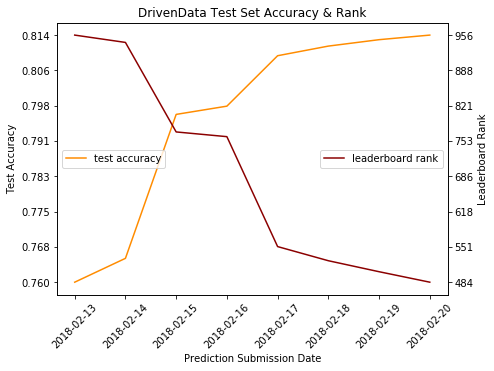

In [7]:
fig, ax1 = plt.subplots(figsize=(7,5))
ax2 = ax1.twinx()
ax1.plot(dates, accuracies, color='darkorange', label='test accuracy')

ax1.set_xlabel('Prediction Submission Date')
ax1.set_ylabel('Test Accuracy')
ax1.set_yticks(np.linspace(min(accuracies),max(accuracies),len(accuracies)))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.legend(loc=6)

ax2.plot(dates, ranks, color='darkred', label='leaderboard rank')
ax2.set_ylabel('Leaderboard Rank')
ax2.set_yticks(np.linspace(min(ranks),max(ranks),len(ranks)))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax2.legend(loc=7)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.title('DrivenData Test Set Accuracy & Rank')
plt.show();

# Minimum Viable Product
Generate random sample of entire dataset to use for Tableau visualizations. Include filter for percent of samples whose class would be predicted accurately.

In [489]:
df['predicted'] = 0
sample = df.sample(frac=.8137, random_state=37).index
df.iloc[:len(sample),:]['predicted'] = 1

/Users/Arjun/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [490]:
df.predicted.value_counts()

1    47306
0    12094
Name: predicted, dtype: int64

In [491]:
df.to_csv('rf_0215-3.csv', index=False)

# Pickle Final Model

In [ ]:
filename = 'finalized_random_forest_model.sav'

In [410]:
# save the model to disk
pickle.dump(rf, open(filename, 'wb'))

In [ ]:
# some time later... load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))